In [1]:
import numpy as np
import numba as nb
import pylab as plt

njit = nb.njit
np.random.seed(0)

# Les paramètres de l'étude. 
- La richesse initiale du porteur est de 1 euro, pour simplifier, mais aussi parce que tous les résultats sont linéaires en $W_0$.
- Son aversion au risque s'exprime par la proportion $\rho$ qu'il accepte de mettre à risque de perte dans son investissement avec la probabilité $\alpha$.
- Le taux sans risques est celui du livret A ([Source](https://www.capital.fr/votre-argent/livret-a-ldds-lep-cel-pee-les-nouveaux-taux-de-votre-epargne-reglementee-au-1er-fevrier-2020-1361121#:~:text=Livret%20A%20%3A%20taux%20%C3%A0%200%2C5%25&text=Pour%20une%20personne%20l'ayant,de%20115%20euros%20par%20an.)).
- On prend pour référence l'ETF Lyxor CAC40 du 1er Avril 2020 au 5 mars 2021 ([Source](https://www.abcbourse.com/download/valeur/CACp)). La moyenne mensuelle des rendements $m$ et l'écart-type $\sigma$ valent $0.0215$ et $0.0613$ respectivement. Il sont calculés avec le script
```python
import pandas as pd
import numpy as np
```
```python
etf = pd.read_csv("CAC.txt", sep = ";", names = ["STOCK_ID", "DATE", "OPEN", "HIGH", "LOW", "CLOSE", "VOLUME"])
etf.DATE = etf.DATE.str[:-2] + "20" + etf.DATE.str[-2:]
etf.DATE = pd.to_datetime(etf.DATE, format = "%d/%m/%Y")
etf = etf[["DATE", "STOCK_ID", "CLOSE"]]
etf = etf.rename(columns = {"CLOSE": "PRICE"})
etf = pd.pivot_table(etf, values='PRICE', index=['DATE'], columns=['STOCK_ID'])
etf = etf.resample("1D").last().interpolate().resample("1M").last()
returns = etf.copy()
for stock in returns.columns:
    returns[stock] = np.log(returns[stock]/returns[stock].shift(1)).values
```
```python
m = returns.mean().values[0]
sigma = returns.std().values[0]
```
- Le porteur modifie sa position tous les premiers du mois pendant un an, *i.e.* $K = 12$.
- Les simulations de Monte-Carlo sont faites avec $S = 1e6$ de tirages (soit un million de tirages).

In [2]:
W0 = 1                 # For easier computations - results are linear anyway in W0
rho = .01              # Aversion au risque (part de sa fortune initiale qu'il accepte de voir disparaître avec 5% de probabilité)
r = 0.005              # taux livret A
m = 0.0215             # From get-mean-std-CAC40-after-outbreak.py output
sigma = 0.0613         # From get-mean-std-CAC40-after-outbreak.py output
S = 100000            # Number of Monte-Carlo simulations

sharpe = (m - r)/sigma # ratio de Sharpe

# Fonctions utiles à la simulation

- Une fonction qui simulent les rendements de l'ETF: elle prend en entrée les valeurs de $m$, $\sigma$ et $S$, elle renvoie en sortie vecteur qui contient les valeurs des rendements simulés $\mu$ tels que $\mu = m + \sigma\epsilon$.

In [3]:
@njit(nogil=True)
def compute_mu(m, sigma, S, set_seed = True):
    if set_seed: np.random.seed(0)
    mu = np.empty(S)
    for s in np.arange(S):
        mu[s] = m + sigma*np.random.normal()
    return mu

- Une fonction qui permet de calculer la valeur actualisée de la richesse du porteur en $k=1$, $\tilde{\mathcal W}$. Pour mémoire, on a 

    $\tilde{\mathcal W} = \mathcal{W}_0 + \frac{\mu - r}{1 + r}\left( \mathcal{W}_0 - c \right)\phi - c.$

    Cette fonction prend en entrée les paramètres $\mathcal{W}_0$, $r$, $\mu$, $\phi$ et $c$ et renvoie en sortie une matrice dont les lignes sont des réalisations indépendantes du processus des richesses (valeurs actualisées à zéro). Les variables $c$ et $\phi$ sont contraintes dans $[0, \mathcal{W}_0]$ et $[0, 1]$ respectivement.

In [4]:
@njit(nogil = True)
def compute_actualized_wealth_one_period(W0, r, mu, phi, c):
    S, = mu.shape
    W = np.zeros(S)
    for s in np.arange(S):
        W[s] = W0 + (mu[s] - r)*(W0 - c)*phi/(1 + r) - c
    return W

- Une fonction qui calcule $\phi^*(c)$, la proportion d'actif risqué investie sur le montant restant après la perception du coupon. Pour rappel,
$\phi^*(c) = \min\left( 1, \frac{1 + r}{\sigma\left( 1.96 - s \right)} \frac{\rho\mathcal{W}_0}{\mathcal{W}_0 - c} \right)$ avec $s = (m - r)/\sigma$.

    Elle prend en entrée $\mathcal{W}_0$, $\rho$, $r$, $m$,  $\sigma$ et un vecteur de valeurs $c$ et rend en sortie un vecteur de valeurs $\phi*$ correspondant.

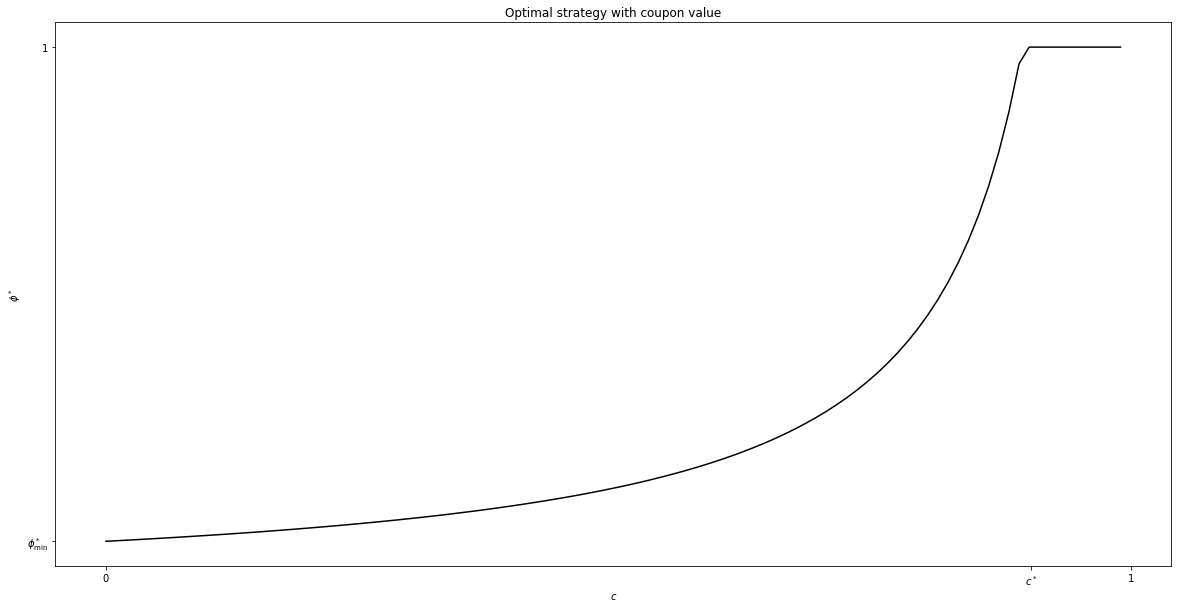

In [5]:
@njit(nogil = True)
def compute_phi_star(W0, rho, r, m, sigma, c):
    N_c = c.shape[0] - 1
    phi_star = np.ones(N_c + 1)
    sharpe = (m - r)/sigma
    constant = (1 + r)/(sigma*(1.96 - sharpe))*rho*W0
    W0_over_N_c = W0/N_c
    for n_c in np.arange(N_c):
        c = W0_over_N_c*n_c
        value = constant/(W0 - c)
        if value >= 1: continue
        phi_star[n_c] = value
    return phi_star

N_c = 100
c = np.arange(0, W0, 1/(N_c + 1))
phi_star = compute_phi_star(W0, rho, r, m, sigma, c)
c_star = W0*(1 - (1 + r)/(sigma*(1.96 - sharpe))*rho)

_ = plt.figure(figsize = (20, 10))
_ = plt.plot(c, phi_star, "k")
_ = plt.ylabel(r"$\phi^*$")
_ = plt.xlabel(r"$c$")
_ = plt.title("Optimal strategy with coupon value")
_ = plt.yticks([phi_star[0], 1], [r"$\phi^*_{\min{}}$", "1"])
_ = plt.xticks([0, c_star, 1], ["0", r"$c^*$", "1"])

## Quelques remarques.

- Comme on peut le voir sur le tracé ci-dessus (exécuter la cellule si ce n'est pas encore fait), passer une certaine valeur $c^*$, il devrait devenir sous-optimal de prendre plus de capital.

    La valeur $c^*$ est obtenue en égalisant à $1$ l'expression $\frac{1 + r}{\sigma\left( 1.96 - s \right)} \frac{\rho\mathcal{W}_0}{\mathcal{W}_0 - c}$, ce qui conduit, sans trop d'effort à

    $c^* = \mathcal{W}_0\left( 1 - \frac{1 + r}{\sigma\left( 1.96 - s \right)} \rho \right)$.

    Au delà de cette valeur, la portion de capital alloué à l'actif risqué est capée car on devrait dépasser le montant disponible à investir. Les gains obtenus vont donc diminuer au fir et à mesure que l'on se verse un coupon plus important.
    

- Dans le cas où l'on ne se verserait pas de coupon, la part $\phi_{\min{}}^*$ dans l'actif risqué vaut

    $\phi_{\min{}}^* = \frac{1 + r}{\sigma\left( 1.96 - s \right)}\rho$. 
    

- Pour caractériser la situation où quoiqu'il arrive le porteur doit tout mettre dans l'actif risqué, égalisons $\phi_{\min{}}^*$ à 1. On trouve une valeur maximale pour $\rho$ égale à 

    $\rho_{\max{}}^* = \frac{\sigma\left( 1.96 - s \right)}{1 + r}$.

    Cette grandeur définit la proportion au dessus de laquelle, le porteur, pour maximiser ses gains, doit tout mettre dans l'actif risqué.

# Analyse de la performance

Pour analyser la performance de la stratégie qui consiste à placer la part $\phi^*(c)$ dans l'actif risqué sur la montant restant après versement du coupon $c$, on va utiliser une méthode de Monte-Carlo.

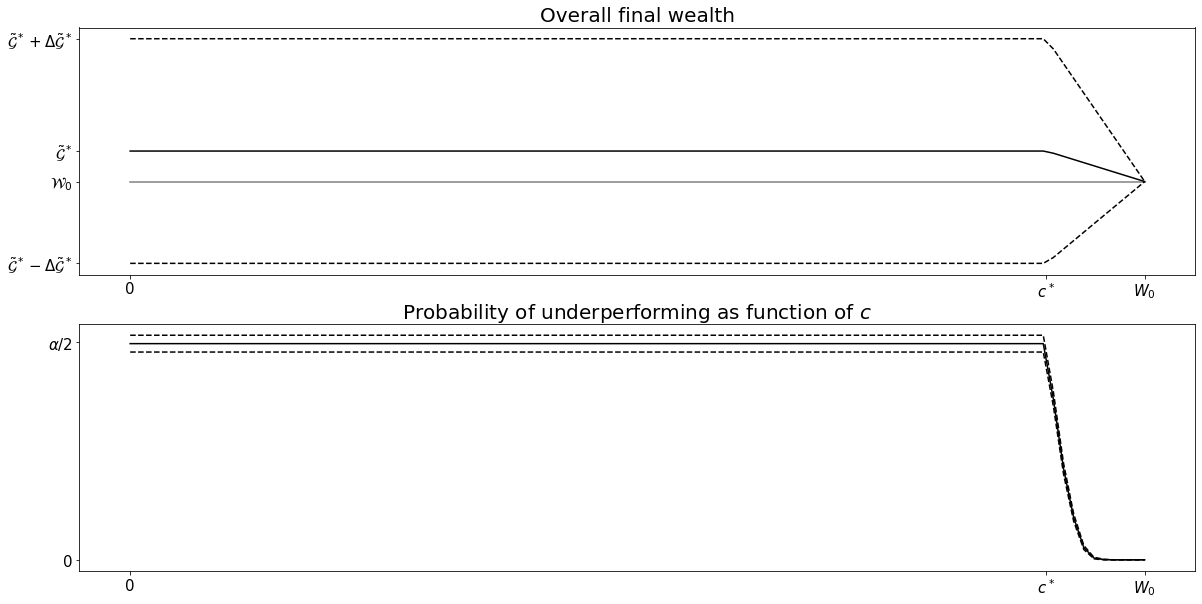

In [6]:
mu = compute_mu(m, sigma, S)
N_c = 100
c = np.arange(0, W0 + 1/N_c, 1/N_c)
phi_star = compute_phi_star(W0, rho, r, m, sigma, c)

G_star = np.zeros(N_c + 1)
Delta_G_star = np.zeros(N_c + 1)
proba_star = np.zeros(N_c + 1)
Delta_proba_star = np.zeros(N_c + 1)
W0_over_N_c = W0/N_c
for n_c in np.arange(N_c + 1):
    W = compute_actualized_wealth_one_period(W0, r, mu, phi_star[n_c], c[n_c])
    G_star[n_c] = (c[n_c] + W).mean()
    Delta_G_star[n_c] = W.std()
    proba_star[n_c] = (c[n_c] + W < (1 - rho)*W0).mean()
    Delta_proba_star[n_c] = 1.96/np.sqrt(S)*(c[n_c] + W < (1 - rho)*W0).std()

_ = plt.figure(figsize = (20, 10))
_ = plt.subplot(211)
_ = plt.plot(c, W0*np.ones_like(G_star), color = 'grey')
_ = plt.plot(c, G_star, 'k-')
_ = plt.plot(c, G_star + Delta_G_star, 'k--')
_ = plt.plot(c, G_star - Delta_G_star, 'k--')
_ = plt.xlabel("")
_ = plt.ylabel("")
_ = plt.title("Overall final wealth", fontsize = 20)
_ = plt.yticks([G_star[0] + Delta_G_star[0], G_star[0], G_star[0] - Delta_G_star[0], 1], [r"$\tilde{\mathcal{G}}^* + \Delta \tilde{\mathcal{G}}^*$", r"$\tilde{\mathcal{G}}^*$", r"$\tilde{\mathcal{G}}^* - \Delta \tilde{\mathcal{G}}^*$", r"$\mathcal{W}_0$"], fontsize = 15)
_ = plt.xticks([0, c_star, 1], ["0", "$c^*$", r"$W_0$"], fontsize = 15)
_ = plt.subplot(212)
_ = plt.plot(c, proba_star, 'k-')
_ = plt.plot(c, proba_star + Delta_proba_star, 'k--')
_ = plt.plot(c, proba_star - Delta_proba_star, 'k--')
_ = plt.xlabel("")
_ = plt.ylabel("")
_ = plt.title("Probability of underperforming as function of " + "$c$", fontsize = 20)
_ = plt.yticks([0, .025], ["0", r"$\alpha/2$"], fontsize = 15)
_ = plt.xticks([0, c_star, 1], ["0", "$c^*$", r"$W_0$"], fontsize = 15)

## Quelques remarques

Comme on peut le voir sur la figure ci-dessus (exécuter la cellule si ce n'est pas encore fait), au delà d'un versement de $c^*$, le porteur perd en possibilité de rendements dans l'actif sans risques. 


Quand le coupon qu'il se verse dépasse $c^*$, tout le montant restant doit être alloué à l'actif sans risque, lui assurant gain moyen sous-optimal $\frac{\mu - r}{1 + r}\left( \mathcal{W}_0 - c \right)$ qui décroît avec l'augmentation des versements en coupon!


Enfin, puisque les gains sont les mêmes jusqu'en $c^*$, d'un point de vue purement de l'investissement financier, il est optimal de se verser le coupon $c^*$.

# Application de cette stratégie avec répétition

Le paragraphe précédent a montré comment le porteur pouvait choisir son coupon pour un investissement en deux périodes. Supposons qu'il garde la même approche entre deux instants de rebalancement: il ne souhait pas, d'une période à l'autre voir plus d'une fraction $\rho$ de son capital disparaître.

## Quelques notations et équations.

- La richesse actualisée en zéro du porteur à l'instant $k$ s'écrit $\tilde{\mathcal{W}}_k$. Entre $k$ et $k+1$ cette richesse connaît une variation

    $\tilde{\mathcal{W}}_{k+1} - \tilde{\mathcal{W}}_k = \left[ \tilde{\mathcal{W}}_k - \min\left( \frac{c}{\left( 1 + r \right)^{k + 1}}, \tilde{\mathcal{W}}_k \right) \right] \phi^*_k(c) \frac{\mu_k - r}{1 + r} - \frac{c}{\left( 1 + r \right)^{k + 1}}$.

    Le coupon doit être actualisé car il est considéré comme fixe à chaque période de temps (un peu comme un bond). Aussi, on ajoute une borne au coupon effectivement perçu si la richesse à l'instant $k$ ne permet pas de le verser intégralement. Dans un tel cas, on distribue l'entièreté de la richesse à cet instant.
    

- La stratégie d'investissement $\phi^*_k(c)$ est la même à chaque période. On notera une dépendance en le temps provenant de la variation de richesse à disposition au cours de l'investissement.

    $\phi^*_k(c) = \min\left( 1, \frac{1 + r}{\sigma\left( 1.96 - s \right)} \frac{\rho\tilde{\mathcal{W}}_k}{\tilde{\mathcal{W}}_k -  c/\left( 1 + r \right)^{k + 1}} \right)$
    
    Elle assure au porteur qu'entre chaque période, la probabilité qu'il perde une fraction $\rho$ de son capital à l'instant $k$ ne dépasse pas 5%.


- Le gain pour l'investisseur en $K$ est la somme des revenus qu'il a réussi à obtenir des ses placements risqué. Ce que l'on notera

    $\tilde{\mathcal{G}}_{K} = \sum_{k = 0}^{K - 1}\left( \tilde{\mathcal{W}}_k - \frac{c}{\left( 1 + r \right)^{k}} \right) \phi^*_k(c) \frac{\mu_k - r}{1 + r} $
    

Cherchons comment ce gain ce comporte avec une méthode de Monte-Carlo.

On supposera que l'investisseur à une horizon de temps $K$ qui sera précisé par la suite.

## Définitions de fonctions qui généralisent les précédentes

In [7]:
@njit(nogil = True)
def compute_investment_data(c, W0, rho, r, m, sigma, K, set_seed = False):
    mu = compute_mu(m, sigma, K, set_seed = set_seed)
    phi = np.zeros(K)
    received_coupons = np.zeros(K)
    W = np.zeros(K + 1)
    G = np.zeros(K + 1)
    W[0] = W0
    G[0] = W0
    for k in np.arange(K):
        W_k = W[k]
        c_k = c/np.power(1 + r, k)
        if W_k <= c_k:
            received_coupon_k = W_k
            phi_k = 0               # Cette valeur n'est pas importante donc on la fixe volontairement à 0
        else:
            received_coupon_k = c_k
            phi_k = np.minimum(1, (1 + r)/(sigma*(1.96 - sharpe))*rho*W_k/(W_k - c_k))
        psi_k = (W_k - c_k)*phi_k
        Delta_G_K = psi_k*(mu[k] - r)/(1 + r)
        G[k + 1] = G[k] + Delta_G_K
        W[k + 1] = np.maximum(W_k - c_k + Delta_G_K, 0)
        received_coupons[k] = received_coupon_k
        phi[k] = phi_k
    return phi, received_coupons, W, G

@njit(nogil = True)
def compute_investment_data_Monte_Carlo(c, W0, rho, r, m, sigma, K, S):
    phi = np.empty((S, K))
    received_coupons = np.empty((S, K))
    W = np.empty((S, K + 1))
    G = np.empty((S, K + 1))
    set_seed = False
    for s in np.arange(S):
        if s == 0: 
            set_seed = True
        else:
            set_seed = False
        phi[s, :], received_coupons[s, :], W[s, :], G[s, :] = compute_investment_data(c, W0, rho, r, m, sigma, K, set_seed = set_seed)
    return phi, received_coupons, W, G

In [8]:
@njit(nogil = True)
def compute_performance(coupons, W0, rho, r, m, sigma, K, S):
    probability_negative = np.zeros_like(coupons)
    Delta_probability_negative = np.zeros_like(coupons)
    G_star_K = np.zeros_like(coupons)
    Delta_G_star_K = np.zeros_like(coupons)
    for n_c in np.arange(coupons.shape[0]):
        c = coupons[n_c]
        phi, received_coupons, W, G = compute_investment_data_Monte_Carlo(c, W0, rho, r, m, sigma, K, S)
        probability_negative[n_c] = (G[:, -1] < (1 - rho*W0)).mean()
        Delta_probability_negative[n_c] = 1.96/np.sqrt(S)*(G[:, -1] < (1 - rho*W0)).std()
        G_star_K[n_c] = G[:, -1].mean()
        Delta_G_star_K[n_c] = G[:, -1].std()
    return probability_negative, Delta_probability_negative, G_star_K, Delta_G_star_K    

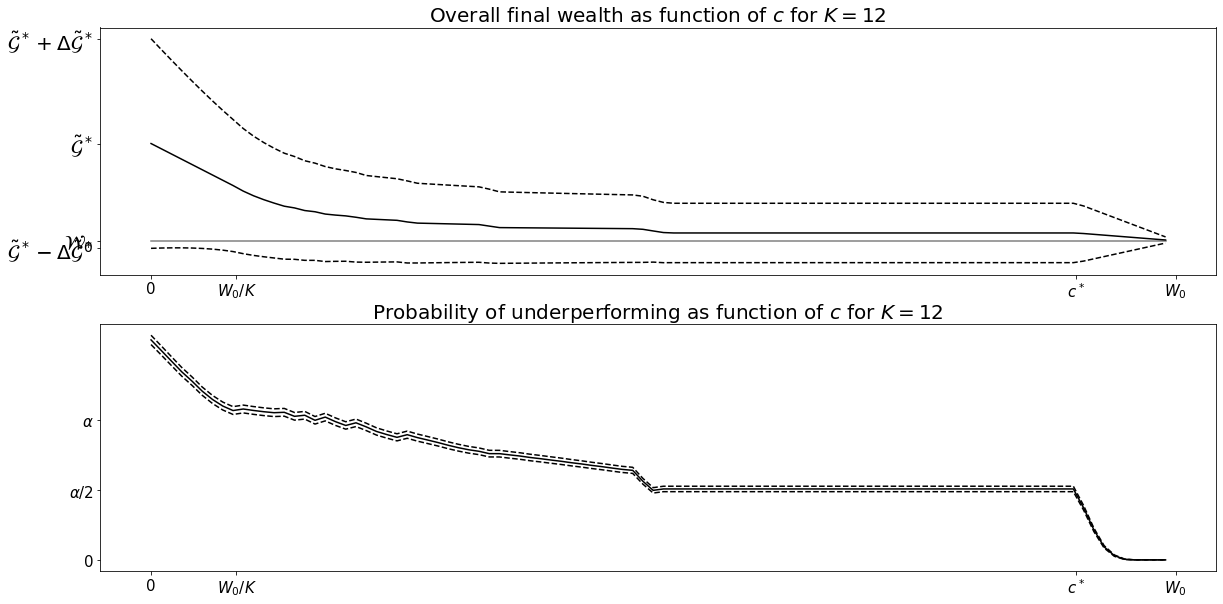

In [9]:
K = 12
coupons = W0*np.arange(0, 100)/100

probability_negative, Delta_probability_negative, G_star_K, Delta_G_star_K = compute_performance(coupons, W0, rho, r, m, sigma, K, S)

_ = plt.figure(figsize = (20, 10))
_ = plt.subplot(211)
_ = plt.plot(coupons, W0*np.ones_like(G_star_K), color = 'grey')
_ = plt.plot(coupons, G_star_K, 'k-')
_ = plt.plot(coupons, G_star_K + Delta_G_star_K, 'k--')
_ = plt.plot(coupons, G_star_K - Delta_G_star_K, 'k--')
_ = plt.xlabel("")
_ = plt.ylabel("")
_ = plt.title("Overall final wealth as function of " + r"$c$ for " + r"$K = " + str(K) + "$", fontsize = 20)
_ = plt.yticks([G_star_K[0] + Delta_G_star_K[0], G_star_K[0], G_star_K[0] - Delta_G_star_K[0], 1], [r"$\tilde{\mathcal{G}}^* + \Delta \tilde{\mathcal{G}}^*$", r"$\tilde{\mathcal{G}}^*$", r"$\tilde{\mathcal{G}}^* - \Delta \tilde{\mathcal{G}}^*$", r"$\mathcal{W}_0$"], fontsize = 20)
_ = plt.xticks([0, 1/K, c_star, 1], ["0", "$W_0/K$", r"$c^*$", r"$W_0$"], fontsize = 15)
_ = plt.subplot(212)
_ = plt.plot(coupons, probability_negative, 'k-')
_ = plt.plot(coupons, probability_negative + Delta_probability_negative, 'k--')
_ = plt.plot(coupons, probability_negative - Delta_probability_negative, 'k--')
_ = plt.xlabel("")
_ = plt.ylabel("")
_ = plt.title("Probability of underperforming as function of " + "$c$" + r" for $K = " + str(K) + "$", fontsize = 20)
_ = plt.yticks([0, .025, 0.05], ["0", r"$\alpha/2$", r"$\alpha$"], fontsize = 15)
_ = plt.xticks([0, 1/K, c_star, 1], ["0", "$W_0/K$", r"$c^*$", r"$W_0$"], fontsize = 15)

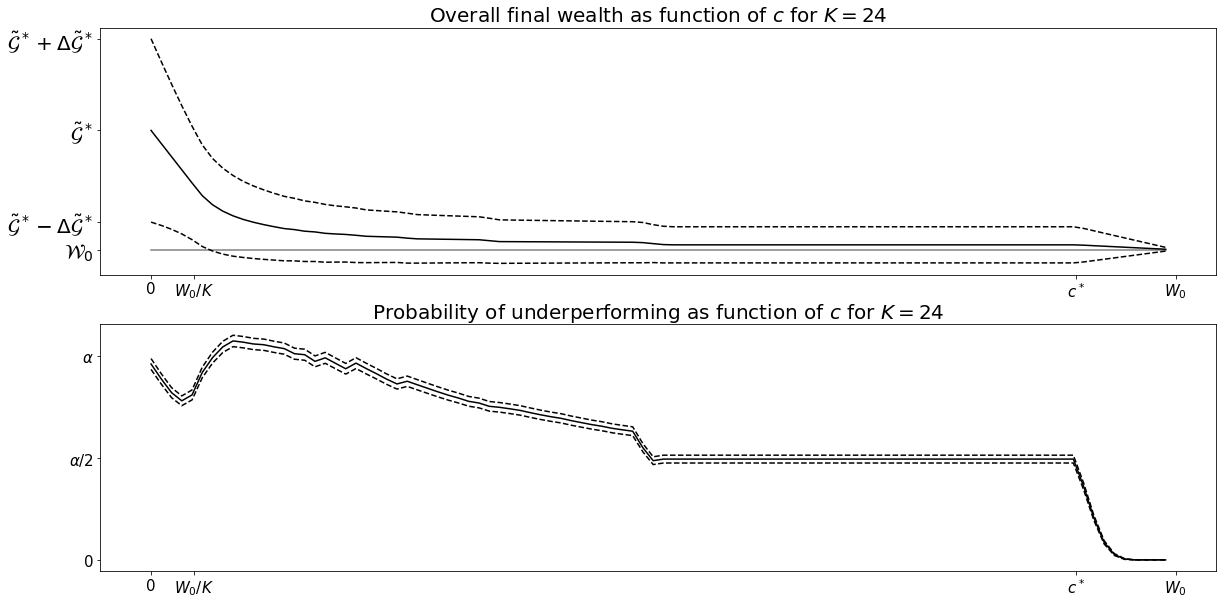

In [10]:
K = 24
coupons = W0*np.arange(0, 100)/100

probability_negative, Delta_probability_negative, G_star_K, Delta_G_star_K = compute_performance(coupons, W0, rho, r, m, sigma, K, S)

_ = plt.figure(figsize = (20, 10))
_ = plt.subplot(211)
_ = plt.plot(coupons, W0*np.ones_like(G_star_K), color = 'grey')
_ = plt.plot(coupons, G_star_K, 'k-')
_ = plt.plot(coupons, G_star_K + Delta_G_star_K, 'k--')
_ = plt.plot(coupons, G_star_K - Delta_G_star_K, 'k--')
_ = plt.xlabel("")
_ = plt.ylabel("")
_ = plt.title("Overall final wealth as function of " + r"$c$ for " + r"$K = " + str(K) + "$", fontsize = 20)
_ = plt.yticks([G_star_K[0] + Delta_G_star_K[0], G_star_K[0], G_star_K[0] - Delta_G_star_K[0], 1], [r"$\tilde{\mathcal{G}}^* + \Delta \tilde{\mathcal{G}}^*$", r"$\tilde{\mathcal{G}}^*$", r"$\tilde{\mathcal{G}}^* - \Delta \tilde{\mathcal{G}}^*$", r"$\mathcal{W}_0$"], fontsize = 20)
_ = plt.xticks([0, 1/K, c_star, 1], ["0", "$W_0/K$", r"$c^*$", r"$W_0$"], fontsize = 15)
_ = plt.subplot(212)
_ = plt.plot(coupons, probability_negative, 'k-')
_ = plt.plot(coupons, probability_negative + Delta_probability_negative, 'k--')
_ = plt.plot(coupons, probability_negative - Delta_probability_negative, 'k--')
_ = plt.xlabel("")
_ = plt.ylabel("")
_ = plt.title("Probability of underperforming as function of " + "$c$" + r" for $K = " + str(K) + "$", fontsize = 20)
_ = plt.yticks([0, .025, 0.05], ["0", r"$\alpha/2$", r"$\alpha$"], fontsize = 15)
_ = plt.xticks([0, 1/K, c_star, 1], ["0", "$W_0/K$", r"$c^*$", r"$W_0$"], fontsize = 15)

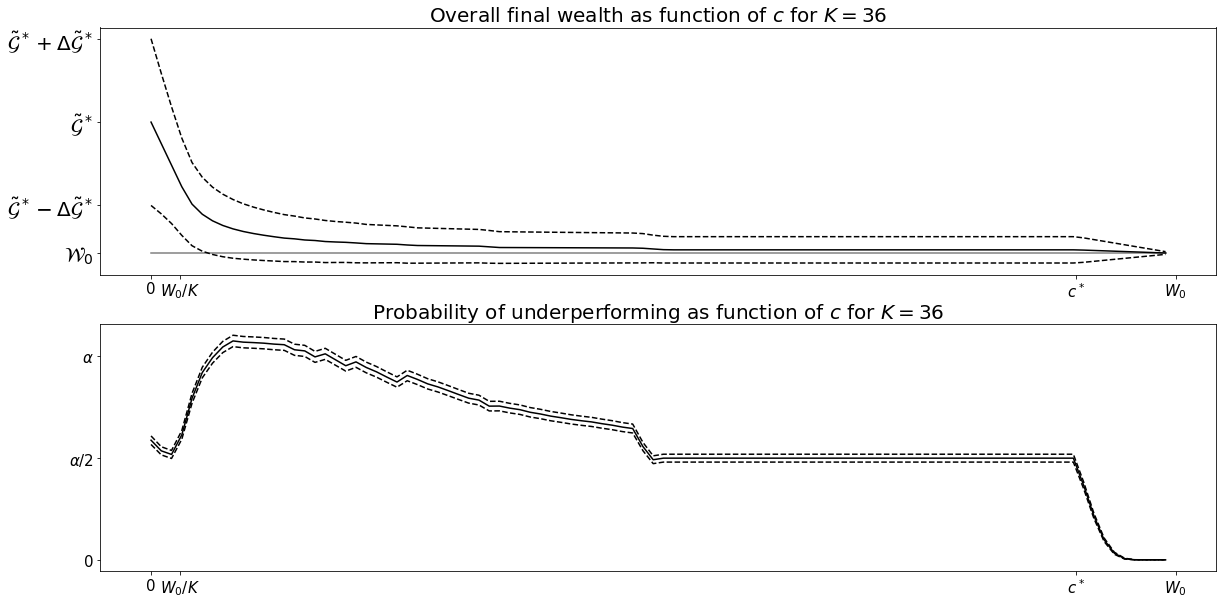

In [11]:
K = 36
coupons = W0*np.arange(0, 100)/100

probability_negative, Delta_probability_negative, G_star_K, Delta_G_star_K = compute_performance(coupons, W0, rho, r, m, sigma, K, S)

_ = plt.figure(figsize = (20, 10))
_ = plt.subplot(211)
_ = plt.plot(coupons, W0*np.ones_like(G_star_K), color = 'grey')
_ = plt.plot(coupons, G_star_K, 'k-')
_ = plt.plot(coupons, G_star_K + Delta_G_star_K, 'k--')
_ = plt.plot(coupons, G_star_K - Delta_G_star_K, 'k--')
_ = plt.xlabel("")
_ = plt.ylabel("")
_ = plt.title("Overall final wealth as function of " + r"$c$ for " + r"$K = " + str(K) + "$", fontsize = 20)
_ = plt.yticks([G_star_K[0] + Delta_G_star_K[0], G_star_K[0], G_star_K[0] - Delta_G_star_K[0], 1], [r"$\tilde{\mathcal{G}}^* + \Delta \tilde{\mathcal{G}}^*$", r"$\tilde{\mathcal{G}}^*$", r"$\tilde{\mathcal{G}}^* - \Delta \tilde{\mathcal{G}}^*$", r"$\mathcal{W}_0$"], fontsize = 20)
_ = plt.xticks([0, 1/K, c_star, 1], ["0", "$W_0/K$", r"$c^*$", r"$W_0$"], fontsize = 15)
_ = plt.subplot(212)
_ = plt.plot(coupons, probability_negative, 'k-')
_ = plt.plot(coupons, probability_negative + Delta_probability_negative, 'k--')
_ = plt.plot(coupons, probability_negative - Delta_probability_negative, 'k--')
_ = plt.xlabel("")
_ = plt.ylabel("")
_ = plt.title("Probability of underperforming as function of " + "$c$" + r" for $K = " + str(K) + "$", fontsize = 20)
_ = plt.yticks([0, .025, 0.05], ["0", r"$\alpha/2$", r"$\alpha$"], fontsize = 15)
_ = plt.xticks([0, 1/K, c_star, 1], ["0", "$W_0/K$", r"$c^*$", r"$W_0$"], fontsize = 15)